In [1]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import seaborn as sns
import contextily as ctx
import copy
from scipy.stats import norm
from plot_functions import plot_vakindeling, plot_assessment_betas, plot_assessment_probabilities, plot_pf_length_cost, get_cum_costs, add_characteristic_columns, map_of_measures, map_of_soil_dimensions, plot_soil_dim_map, map_of_measure_cost, map_of_measure_cost_diff
from load_output import read_assessment_betas, get_traject_prob_development
sns.set_style('whitegrid')

## Case informatie

In [2]:
dijktraject = '16-1'
close_figures = True
shape_dir = Path(r'c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_Prioritering WSRL\Rekenresultaten_Final\Berekening 16-1')
results_dir = shape_dir.joinpath('rerun')
run = 'results'
shapefile = gpd.read_file(shape_dir.joinpath('vakindeling_traject16_1.shp'))

#relevante lengtes voor figuren urgentie (3 waarden):
lengtes_urgentie = [3000, 6000, 9000]

## Vakindeling

In [3]:
shapefile.crs='EPSG:28992'
shapefile = shapefile.to_crs(epsg=3857)
# shapefile.to_crs(epsg=4326)
for count, section in shapefile.iterrows():
    if len(section.NUMMER) ==1:
        #pad 0:
        shapefile.loc[count,'NUMMER']= '{:02d}'.format(np.int32(section.NUMMER))
shapefile = shapefile.rename(columns={'NUMMER':'vaknaam','IN_ANALYSE':'in_analyse','MEAS_START':'m_start','MEAS_END':'m_eind'})

In [4]:
plot_vakindeling(shapefile, results_dir.joinpath(run, 'extra_resultaten', 'vakindeling.png'),close_output=close_figures)


## Resultaten beoordeling

In [5]:
#lees beoordelingsresultaten
InitialAssessmentBetas, InitialAssessmentProbabilities = read_assessment_betas(results_dir.joinpath(run, 'InitialAssessment_Betas.csv'))


In [6]:
#plot beoordeling
plot_assessment_betas(shapefile, InitialAssessmentBetas, results_dir.joinpath(run,'extra_resultaten'), year = 2025,close_output=close_figures)

plot_assessment_probabilities(shapefile, InitialAssessmentProbabilities, results_dir.joinpath(run,'extra_resultaten'), year = 2025,close_output=close_figures)

plot_assessment_probabilities(shapefile, InitialAssessmentProbabilities, results_dir.joinpath(run,'extra_resultaten'), year = 2075,close_output=close_figures)



## Maatregelen

### Versterkte lengte

In [7]:
#bepaal optimalisatie data van beide varianten
initial_beta = InitialAssessmentBetas.loc[InitialAssessmentBetas.mechanism!='Section'].set_index(['name','mechanism']).drop(columns=['Length'])
section_lengths = InitialAssessmentBetas.loc[InitialAssessmentBetas.mechanism=='Section'].set_index('name')['Length']
vr = {}

#optimale maatregelen
vr['optimal_measures'] = pd.read_csv(results_dir.joinpath(run,'TakenMeasures_Optimal_Veiligheidsrendement.csv'),index_col=2)
#maatregelvolgorde, optie 1: eerste investering als eerste
vr['taken_measures'] = pd.read_csv(results_dir.joinpath(run,'TakenMeasures_Veiligheidsrendement.csv'),index_col=0)
vr['section_order'], vr['traject_probs'] = get_traject_prob_development(vr['optimal_measures'],
                                                                  vr['taken_measures'],
                                                                  initial_beta,
                                                                  option_dir = results_dir.joinpath(run))

dsn = {}
#optimale maatregelen referentie
dsn['optimal_measures'] = pd.read_csv(results_dir.joinpath(run,'FinalMeasures_Doorsnede-eisen.csv'),index_col=2)
#maatregelvolgorde, optie 1: eerste investering als eerste
dsn['taken_measures'] = pd.read_csv(results_dir.joinpath(run,'TakenMeasures_Doorsnede-eisen.csv'),index_col=0)
dsn['section_order'], dsn['traject_probs'] = get_traject_prob_development(dsn['optimal_measures'],
                                                                    dsn['taken_measures'] ,
                                                                    initial_beta, 
                                                                    option_dir = results_dir.joinpath(run),
                                                                    calc_type='Doorsnede-eisen')





In [8]:
#plot versterkte lengte versus faalkans
years = [2025, 2050,2075]
for year in years:
    plot_pf_length_cost(vr, dsn,
                                initial_beta, shapefile, 
                                results_dir.joinpath(run,'extra_resultaten'),
                                section_lengths,
                                mode= 'Length',
                                year = year,
                               close_output=close_figures)


In [9]:
#plot kosten versus faalkans
years = [2025, 2050,2075]
for year in years:
    plot_pf_length_cost(vr, dsn,
                                initial_beta, shapefile, 
                                results_dir.joinpath(run,'extra_resultaten'),
                                section_lengths,
                                mode= 'Cost',
                                year = year,
                                close_output=close_figures)



In [10]:
year_ind = 3
year = np.int_(InitialAssessmentBetas.drop(columns=['name','mechanism','Length']).columns.values[year_ind])+2025
fig, ax = plt.subplots(figsize=(10,4))
x_vr = pd.concat([pd.Series([0]), get_cum_costs(vr['section_order'],vr['optimal_measures'])])
x_dsn = pd.concat([pd.Series([0]), get_cum_costs(dsn['section_order'],dsn['optimal_measures'])])
ax.plot(x_vr,-norm.ppf(vr['traject_probs'][:,year_ind]),label= 'Veiligheidsrendement',color='red',marker='.')
ax.plot(x_dsn,-norm.ppf(dsn['traject_probs'][:,year_ind]),label= 'Doorsnede-eisen',color='green',marker='.')
ax.hlines(-norm.ppf(1./10000),0,shapefile.m_eind.max(),label='Ondergrens',color='k',linestyle='--')

ax.hlines(-norm.ppf(1./30000),0,shapefile.m_eind.max(),label='Signaleringswaarde',color='k',linestyle=':')
#text labels vr:
for count, section in enumerate(vr['section_order'],1):
    if (count % 2) == 0:
        ax.text(x_vr.iloc[count],4.5,section.strip('DV'),rotation=90,verticalalignment='top',color='red')
    else:
        ax.text(x_vr.iloc[count],4.5,section.strip('DV'),rotation=90,verticalalignment='bottom',color='red')
        
#text labels dsn:
for count, section in enumerate(dsn['section_order'],1):
    if (count % 2) == 0:
        ax.text(x_dsn.iloc[count],5,section.strip('DV'),rotation=90,verticalalignment='top',color='green')
    else:
        ax.text(x_dsn.iloc[count],5,section.strip('DV'),rotation=90,verticalalignment='bottom',color='green')
# ax.set_yscale('log')
x_max_right = np.max([get_cum_costs(vr['section_order'],vr['optimal_measures']).max(),get_cum_costs(dsn['section_order'],dsn['optimal_measures']).max()])
ax.set_xlim(left=0,right=x_max_right)
ax.set_ylim(top=5.5)
ax.set_title('Betrouwbaarheidsindex i.r.t. verdisconteerde kosten ({})'.format(year))
ax.set_ylabel('Betrouwbaarheidsindex op trajectniveau')
ax.set_xlabel('Verdisconteerde kosten in M€')
ax.legend(loc='lower right')
plt.savefig(results_dir.joinpath(run,'extra_resultaten','kosten vs beta in {}.png'.format(year)),dpi=300,bbox_inches='tight')
plt.close()

Vergelijking optimalisatiepad, versus veiligheidsrendement opgebost per vak.

In [11]:
colors = sns.cubehelix_palette(n_colors=2, start=2.3, rot=1, gamma=1, hue=1.0, light=0.7, dark=0.2)

year_ind = 0 #2025
year = np.int_(InitialAssessmentBetas.drop(columns=['name','mechanism','Length']).columns.values[year_ind])+2025
fig, ax = plt.subplots(figsize=(10,4))
x_vr = pd.concat([pd.Series([0]), get_cum_costs(vr['section_order'],vr['optimal_measures'])])
x_dsn = pd.concat([pd.Series([0]), get_cum_costs(dsn['section_order'],dsn['optimal_measures'])])
ax.plot(x_vr,-norm.ppf(vr['traject_probs'][:,year_ind]),label= 'Veiligheidsrendement',color=colors[0],marker='.')
ax.plot(x_dsn,-norm.ppf(dsn['traject_probs'][:,year_ind]),label= 'Doorsnede-eisen',color=colors[1],marker='.')

optimal_path = pd.read_csv(results_dir.joinpath(run, 'Beta vs LCC_Optimized investment_t2025.csv'),index_col=0)
ax.plot(optimal_path.Cost,optimal_path.beta,color=colors[0],linestyle='--',label='Optimaal pad VR')

dsn_path = pd.read_csv(results_dir.joinpath(run, 'Beta vs LCC_Target reliability based investment_t2025.csv'),index_col=0)
# ax.plot(dsn_path.Cost,dsn_path.beta,color=colors[1],linestyle='--',label='Pad doorsnede-eisen')

ax.hlines(-norm.ppf(1./10000),0,shapefile.m_eind.max(),label='Ondergrens',color='k',linestyle='--')
ax.hlines(-norm.ppf(1./30000),0,shapefile.m_eind.max(),label='Signaleringswaarde',color='k',linestyle=':')


ax.set_xlim(left=0,right=get_cum_costs(dsn['section_order'],dsn['optimal_measures']).max())
ax.set_ylim(top=5.5)
ax.set_title('Betrouwbaarheidsindex i.r.t. verdisconteerde kosten ({})'.format(year))
ax.set_ylabel('Betrouwbaarheidsindex op trajectniveau')
ax.set_xlabel('Verdisconteerde kosten in M€')
ax.legend(loc='lower right')
plt.savefig(results_dir.joinpath(run,'extra_resultaten','vergelijking optimalisatiepad {}.png'.format(year)),dpi=300,bbox_inches='tight')
plt.close()

## Resultaten

In [12]:
def add_characteristic_columns(result_df):
    #cleaning data
    for count, line in result_df.iterrows():
        try:
            result_df.loc[count,'Section'] = line['Section'].strip('DV')
        except:
            pass
    result_df['In 2045'] = result_df['ID'].str.contains("1", case=False)
    result_df['Stabiliteitsscherm'] = result_df['ID'].str.contains("4|7", case=False)
    result_df['VZG'] = result_df['ID'].str.contains("5", case=False)
    result_df['Diepwand'] = result_df['ID'].str.contains("6", case=False)
    return result_df
                
GreedyResult = pd.read_csv(results_dir.joinpath(run,'TakenMeasures_Optimal_Veiligheidsrendement.csv'))
GreedyResult = add_characteristic_columns(GreedyResult)
GreedyResult = shapefile.merge(GreedyResult,left_on='vaknaam',right_on='Section')
map_of_measures(GreedyResult,close_output=close_figures,output_dir = results_dir.joinpath(run,'extra_resultaten'))

DsnResult = pd.read_csv(results_dir.joinpath(run,'FinalMeasures_Doorsnede-eisen.csv'))
DsnResult = add_characteristic_columns(DsnResult)
DsnResult = shapefile.merge(DsnResult,left_on='vaknaam',right_on='Section')
map_of_measures(DsnResult,data_type = 'Doorsnede-eisen',close_output=close_figures, output_dir = results_dir.joinpath(run,'extra_resultaten'))


C:\Users\klerk_wj\Miniconda3\envs\vr_preprocessing\lib\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


In [13]:
map_of_soil_dimensions(GreedyResult,results_dir.joinpath(run,'extra_resultaten','dimensies_grond_vr.png'),close_output=close_figures)
map_of_soil_dimensions(DsnResult,results_dir.joinpath(run,'extra_resultaten','dimensies_grond_dsn.png'),close_output=close_figures)

In [14]:
plot_soil_dim_map(GreedyResult,results_dir.joinpath(run,'extra_resultaten'),close_output=close_figures)
plot_soil_dim_map(DsnResult,results_dir.joinpath(run,'extra_resultaten'),method = 'Doorsnede-eisen',close_output=close_figures)

In [15]:
map_of_measure_cost(GreedyResult,output_dir = results_dir.joinpath(run, 'extra_resultaten'))
map_of_measure_cost(DsnResult,output_dir = results_dir.joinpath(run, 'extra_resultaten'), data_type = 'Doorsnede-eisen')

GreedyResult['verschil'] = GreedyResult.LCC - DsnResult.LCC
map_of_measure_cost_diff(GreedyResult,output_dir = results_dir.joinpath(run, 'extra_resultaten'), dif_col = 'verschil',close_output=close_figures)


## Urgentie van vakken

In [16]:
def get_N_urgent_sections(section_lengths,section_order,n=20):
    sections = []
    for section in section_order:
        #get length
        length = section_lengths.loc[section.strip('DV')]
        #add to sections
        sections.append(section.strip('DV'))
        #if len(sections) exceeds then stop
        if len(sections) == n:
            return pd.DataFrame([True]*len(sections),index=sections,columns=['scope ' + str(n) + ' vakken'])

def get_L_urgent_meters(section_lengths,section_order, l=20000):
    total_length = 0
    sections = []
    for section in section_order:
        #get length
        length = section_lengths.loc[section.strip('DV')]
        #add to sections
        sections.append(section.strip('DV'))
        total_length += length
        if total_length>l:
            # return sections, total_length
            return pd.DataFrame([True]*len(sections),index=sections,columns=['scope ' + str(np.int32(l/1000)) + ' km']), total_length  
            


In [21]:
scopes = {}
for l_max in lengtes_urgentie:
    scopes['scope {}'.format(int(l_max))], l_found = get_L_urgent_meters(section_lengths,vr['section_order'],l=l_max)

subset_greedy = copy.deepcopy(GreedyResult)[['OBJECTID', 'vaknaam','geometry','VAKLENGTE']]
for key in scopes.keys():
    subset_greedy = subset_greedy.merge(scopes[key], left_on='vaknaam',right_index=True,how='left')
subset_greedy = subset_greedy.fillna(value=False)


In [22]:
#grootste veiligheidstekort:
veiligheidstekort = shapefile.merge(InitialAssessmentBetas.loc[InitialAssessmentBetas.mechanism == 'Section'],left_on='vaknaam',right_on='name')
veiligheidstekort = veiligheidstekort.sort_values('0').reset_index(drop=True)
veiligheidstekort['cumulatieve lengte'] =veiligheidstekort.Length.cumsum()

In [24]:
subset_greedy

,OBJECTID,vaknaam,geometry,VAKLENGTE,scope 3 km,scope 6 km,scope 9 km
0,9,09,"LINESTRING (553707.136 6768828.380, 553706.151...",147.000000,False,False,False
1,10,10,"LINESTRING (553528.337 6768861.127, 553514.452...",129.000000,False,False,True
2,11,11,"LINESTRING (553388.755 6768984.079, 553388.454...",640.000000,False,False,True
3,13,13A,"LINESTRING (552854.355 6769457.584, 552846.089...",340.000000,False,False,True
4,14,13B,"LINESTRING (552362.306 6769318.015, 552362.264...",842.000000,False,False,False
5,15,14,"LINESTRING (551122.670 6769844.035, 551098.299...",271.000000,False,False,False
6,16,15,"LINESTRING (550751.434 6770074.629, 550742.733...",428.000000,False,False,False
7,17,16,"LINESTRING (550342.005 6769631.786, 550330.547...",578.000000,False,False,True
8,18,17,"LINESTRING (550155.338 6770483.780, 550153.431...",458.000000,False,False,True
9,19,18,"LINESTRING (549469.119 6770733.482, 549459.143...",744.000000,True,True,True


KeyError: 'scope 9000'

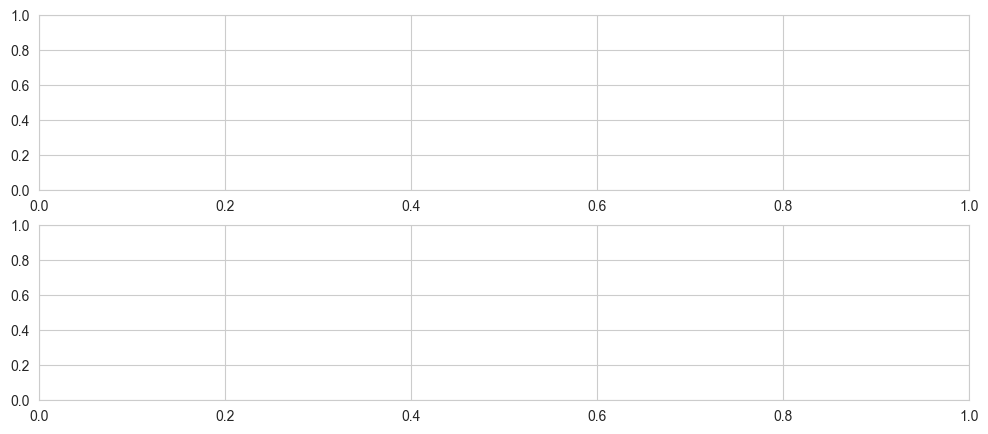

In [23]:
colors = sns.color_palette('husl',n_colors=4)
#scope 5, 8, 11 km:
fig,ax = plt.subplots(figsize=(12,5),nrows=2)
subset_greedy.loc[subset_greedy['scope {}'.format(lengtes_urgentie[2])]].plot(ax=ax[0],categorical=True,legend=True,color=colors[3],linewidth=4,label='{} km'.format(int(lengtes_urgentie[2]/1000)))
subset_greedy.loc[subset_greedy['scope {}'.format(lengtes_urgentie[1])]].plot(ax=ax[0],categorical=True,legend=True,color=colors[1],linewidth=4,label='{} km'.format(int(lengtes_urgentie[1]/1000)))
subset_greedy.loc[subset_greedy['scope {}'.format(lengtes_urgentie[0])]].plot(ax=ax[0],categorical=True,legend=True,color=colors[0],linewidth=4,label='{} km'.format(int(lengtes_urgentie[0]/1000)))


ctx.add_basemap(ax[0],source=ctx.providers.Stamen.TonerLite)
ax[0].legend()
ax[0].set_title('Urgentste km o.b.v. veiligheidsrendement')

veiligheidstekort.loc[0:veiligheidstekort.loc[veiligheidstekort['cumulatieve lengte']>lengtes_urgentie[2]].index[0]].plot(ax=ax[1],categorical=True,legend=True,color=colors[3],linewidth=4,label='{} km'.format(int(lengtes_urgentie[2]/1000)))
veiligheidstekort.loc[0:veiligheidstekort.loc[veiligheidstekort['cumulatieve lengte']>lengtes_urgentie[1]].index[0]].plot(ax=ax[1],categorical=True,legend=True,color=colors[1],linewidth=4,label='{} km'.format(int(lengtes_urgentie[1]/1000)))
veiligheidstekort.loc[0:veiligheidstekort.loc[veiligheidstekort['cumulatieve lengte']>lengtes_urgentie[0]].index[0]].plot(ax=ax[1],categorical=True,legend=True,color=colors[0],linewidth=4,label='{} km'.format(int(lengtes_urgentie[0]/1000)))

ctx.add_basemap(ax[1],source=ctx.providers.Stamen.TonerLite)

ax[1].legend()
ax[1].set_title('Urgentste km o.b.v. veiligheidstekort')

for axes in ax:
    axes.set_xticklabels('')
    axes.set_yticklabels('')
    axes.set_ylim(bottom=axes.get_ylim()[0] - 1000)

plt.savefig(results_dir.joinpath(run,'extra_resultaten','urgentste_vakken_kms.png'),dpi=300,bbox_inches='tight')
plt.close()